# Time Series Analysis, Anomaly Detection and Forecasting on GOOGL Stock Price Data

## Import necessary libreries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

from pandas import datetime
from datetime import datetime, date 

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pylab import rcParams

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle
import plotly.express as px
import plotly.graph_objects as go
import random

import math 

plt.style.use('./d4sci.mplstyle')
%matplotlib inline
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

/var/folders/j4/19v5bck14f94qj1scfkf1m5m0000gn/T/ipykernel_24727/66812729.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Load the dataset 
Dataset is taken from Kaggle : https://www.kaggle.com/datasets/varpit94/google-stock-data

In [2]:
df = pd.read_csv("GOOGL.csv", parse_dates=True)

In [3]:
df

Date         Open         High          Low        Close  \
0     2004-08-19    50.050049    52.082081    48.028027    50.220219   
1     2004-08-20    50.555557    54.594597    50.300301    54.209209   
2     2004-08-23    55.430431    56.796799    54.579578    54.754753   
3     2004-08-24    55.675674    55.855858    51.836838    52.487488   
4     2004-08-25    52.532532    54.054054    51.991993    53.053055   
...          ...          ...          ...          ...          ...   
4426  2022-03-18  2668.489990  2724.879883  2645.169922  2722.510010   
4427  2022-03-21  2723.270020  2741.000000  2681.850098  2722.030029   
4428  2022-03-22  2722.030029  2821.000000  2722.030029  2797.360107   
4429  2022-03-23  2774.050049  2791.770020  2756.699951  2765.510010   
4430  2022-03-24  2784.000000  2832.379883  2755.010010  2831.439941   

        Adj Close    Volume  
0       50.220219  44659096  
1       54.209209  22834343  
2       54.754753  18256126  
3       52.487488  15247337  
4       53.053055   9188602  
...           ...       ...  
4426  2722.510010   2223100  
4427  2722.030029   1341600  
4428  2797.360107   1774800  
4429  2765.510010   1257700  
4430  2831.439941   1317900  

[4431 rows x 7 columns]

In [4]:
# Converting "Date" column type to datetime64[ns]
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4431 non-null   datetime64[ns]
 1   Open       4431 non-null   float64       
 2   High       4431 non-null   float64       
 3   Low        4431 non-null   float64       
 4   Close      4431 non-null   float64       
 5   Adj Close  4431 non-null   float64       
 6   Volume     4431 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 242.4 KB


In [6]:
df.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

There is no null value in any column

## Data Visualization

In [7]:
# Plotting the graph of "Open" field of the dataset

data = [
    go.Scatter(x=df['Date'], y=df['Open'], name='Open'),
    go.Scatter(x=df['Date'], y=df['Close'], name='Close'),
]

fig = go.Figure(data)

fig.update_layout(
    title="Google sock price train",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis=dict(rangeslider=dict(visible=True))
    )


fig.show()

In [8]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

According to the correlation table Open, High, Low, Close and Adj Close are correlated/totally dependent on each other so we can drop High, Low, Close and Adj Close. For further analysis we will only use **"Open"** value

### Running Values

In [9]:
# Plotting the graph of "Open" field of the dataset

data = [
    go.Scatter(x=df['Date'], y=df['Open'], name='Open'),
    go.Scatter(x=df['Date'], y=df['Open'].rolling(window= 30).mean(), name='Open rolling 30 days'),
    go.Scatter(x=df['Date'], y=df['Open'].rolling(window= 60).mean(), name='Open rolling 60 days'),
]

fig = go.Figure(data)

fig.update_layout(
    title="Google sock price train",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis=dict(rangeslider=dict(visible=True))
    )

fig.show()

## Resampling

This time series data was collected as per days. For the better analysis and to get additional information from data we have done Resampling.

Resampling can be done 2 ways. 
1. Upsampling : Converting data to larger scale. Eg. From days to week or month
2. Downsampling : Converting data to smaller scale. Eg. From week to days

Here, we have done upsampling of open price 

In [10]:
resampled_df_7D = df[['Date','Open']].resample('7D', on='Date').sum().reset_index(drop=False)
resampled_df_14D = df[['Date','Open']].resample('15D', on='Date').sum().reset_index(drop=False)

data = [
    go.Scatter(x=df['Date'], y=df['Open'], name='Daily Open Price'),
    go.Scatter(x=resampled_df_7D['Date'], y=resampled_df_7D['Open'], name='Weekly Open Price'),
    go.Scatter(x=resampled_df_14D['Date'], y=resampled_df_14D['Open'], name='Bi-Weekly Open Price'),
]

fig = go.Figure(data)

fig.update_layout(
    title="Resampled",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis=dict(rangeslider=dict(visible=True))
    )

fig.show()

## Bollinger Bands

For the better bollinger bands, we have resampled the data first to bi-weekly and plotted the upper and lower bound of bollinger bands

In [11]:
# As we can see earlier, downsample to weekly could smooth the data and help with analysis
downsample = df[['Date',
                 'Open', 
                ]].resample('14D', on='Date').mean().reset_index(drop=False)

df_copy = downsample.copy()

In [12]:
size = 20
std_dev = 2
df_copy['mov_avg'] = df_copy['Open'].rolling(window=size).mean() 
df_copy['std_dev'] = df_copy['Open'].rolling(window=size).std()  
df_copy['BB_up'] = df_copy['mov_avg'] + (df_copy['std_dev'] * std_dev)
df_copy['BB_low'] = df_copy['mov_avg'] - (df_copy['std_dev'] * std_dev) 

In [13]:
data = [
    go.Scatter(x=df_copy['Date'], y=df_copy['Open'], name='Open'),
    go.Scatter(x=df_copy['Date'], y=df_copy['BB_up'], name='Upper Band'),
    go.Scatter(x=df_copy['Date'], y=df_copy['BB_low'], name='Lower Band'),
]

fig = go.Figure(data)

fig.update_layout(
    title="Bollinger Band",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis=dict(rangeslider=dict(visible=True))
    )

fig.show()

## Stationarity Check

There are 2 checks done in order to determine whether open price data is stationary or not,
1. Rolling Statistics
2. Augmented Dickey Fuller Test

### 1. Rolling Statistics

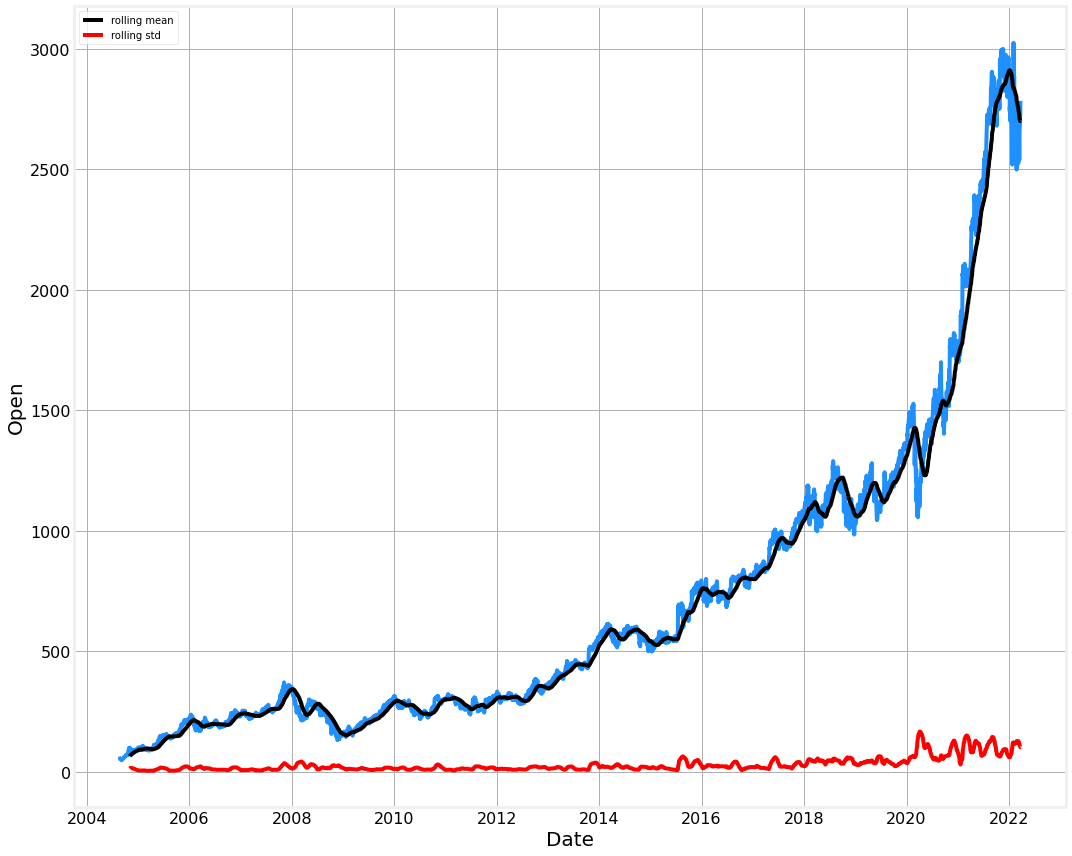

In [14]:
from datetime import date 

rolling_window = 52
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df['Open'], ax=ax, color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Open'].rolling(rolling_window).mean(), ax=ax, color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Open'].rolling(rolling_window).std(), ax=ax, color='red', label='rolling std')

plt.show()

In the plot for Open price and Volume, it can be seen that mean and standard deviation is not constant, so clearly there the series is non-stationary.

#### 2. Augmented Dickey Fuller Test

Augmented Dickey-Fuller (ADF) test is a statistical test also known as unit root test. Unit roots are a reason for non-stationarity.

Null Hypothesis (H0): Time series has a unit root then time series is not stationary.

Alternate Hypothesis (H1): Time series has no unit root then time series is stationary.

1. the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%
    
    **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    
    **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


2. the null hypothesis can be rejects if the test statistic is less than the critical value.
    
    **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    
    **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [15]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Open'].values)
result

ouput_series = pd.Series(result[0:4], index = ['Test Statistics', 'P-value', 'No. Of Lags Used', 'No. Of Observation Used'])
for index, value in result[4].items():
    ouput_series['Critical Value %s'%index] = value
    
print(ouput_series)

Test Statistics               3.106417
P-value                       1.000000
No. Of Lags Used             31.000000
No. Of Observation Used    4399.000000
Critical Value 1%            -3.431837
Critical Value 5%            -2.862197
Critical Value 10%           -2.567120
dtype: float64


So as we can see from the Dickey Fuller Test Statistics that p-value is very large compare to significance level which is 0.5. So we fail to reject the null hypothesis, and can determine that the data has a unit root and is non-stationary. Also, the ADF statistics is greater than critical value at(5%), Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

## Stationarize the series

Now to make time series stationary, there are 2 ways
1. Transformation : Log, Square, Squareroot to stabilize non constant variance
2. Differencing : Subtract current value from previous one

### 1. Transformation 

Dicky Fuller Test Statistics
Test Statistics              -1.619239
P-value                       0.473128
No. Of Lags Used              1.000000
No. Of Observation Used    4429.000000
Critical Value 1%            -3.431827
Critical Value 5%            -2.862193
Critical Value 10%           -2.567117
dtype: float64


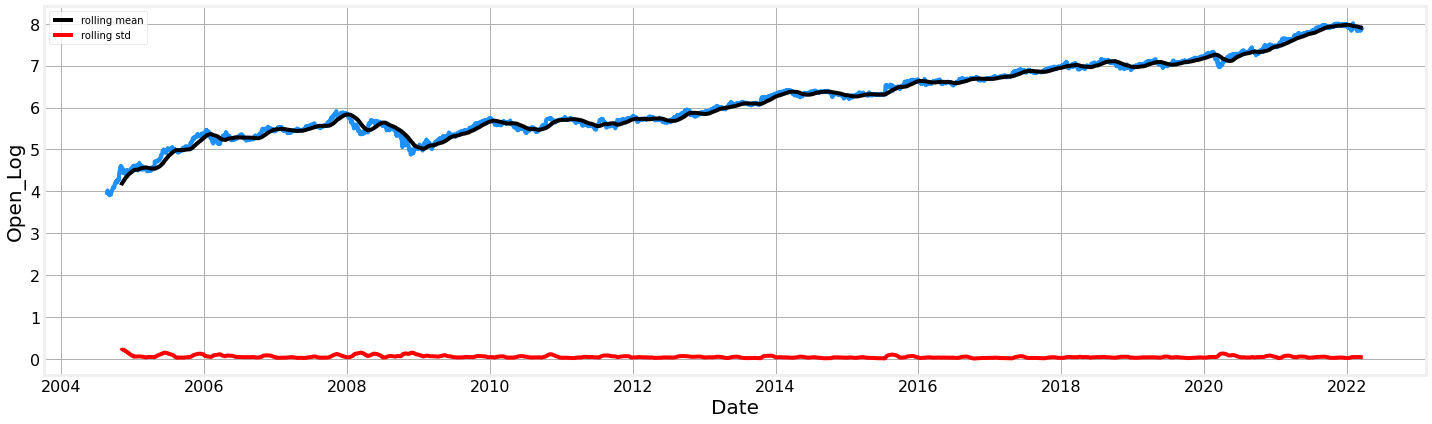

In [16]:
df['Open_Log'] = np.log(abs(df['Open']))

f, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(x=df['Date'], y=df['Open_Log'], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Open_Log'].rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Open_Log'].rolling(rolling_window).std(), color='red', label='rolling std')

# We will perform ADF
result = adfuller(df['Open_Log'].values)
result

print("Dicky Fuller Test Statistics")
ouput_series = pd.Series(result[0:4], index = ['Test Statistics', 'P-value', 'No. Of Lags Used', 'No. Of Observation Used'])
for index, value in result[4].items():
    ouput_series['Critical Value %s'%index] = value
    
print(ouput_series)

Rolling statistics observation : The plot for log transformation value have better result than the previous one but the mean and standard deviation is not constant it's varying with time, so time series is non-stationary.

Augmented Dickey Fuller Test : The p-value is still greater than 0.5, so fail reject the null hypothesis and the series is non-stationary.

### 2. Differencing

Dicky Fuller Test Statistics
Test Statistics           -1.220843e+01
P-value                    1.178880e-22
No. Of Lags Used           3.100000e+01
No. Of Observation Used    4.399000e+03
Critical Value 1%         -3.431837e+00
Critical Value 5%         -2.862197e+00
Critical Value 10%        -2.567120e+00
dtype: float64


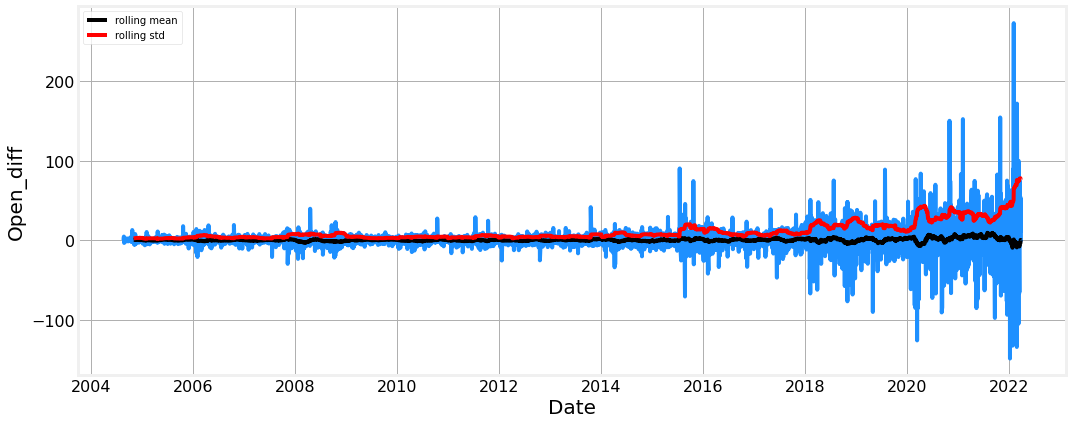

In [17]:
rolling_window = 52
diff = df['Open'].diff(1).dropna()
df['Open_diff'] = np.append([0], diff)

f, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x=df['Date'], y=df['Open_diff'], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['Open_diff'].rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['Open_diff'].rolling(rolling_window).std(), color='red', label='rolling std')

result = adfuller(df['Open_diff'].values)
print("Dicky Fuller Test Statistics")
ouput_series = pd.Series(result[0:4], index = ['Test Statistics', 'P-value', 'No. Of Lags Used', 'No. Of Observation Used'])
for index, value in result[4].items():
    ouput_series['Critical Value %s'%index] = value
    
print(ouput_series)

Rolling statistics observation : The plot for log transformation value have better result than the previous one but the mean and standard deviation is not constant it's varying with time, so time series is non-stationary.

Augmented Dickey Fuller Test : The p-value is now less than 0.5, so fail reject the null hypothesis, the data does not have a unit root and is stationary

## Components of Time Series

We have taken a sample from the time series data to visualize the trend, seasonality and residuals components of time series

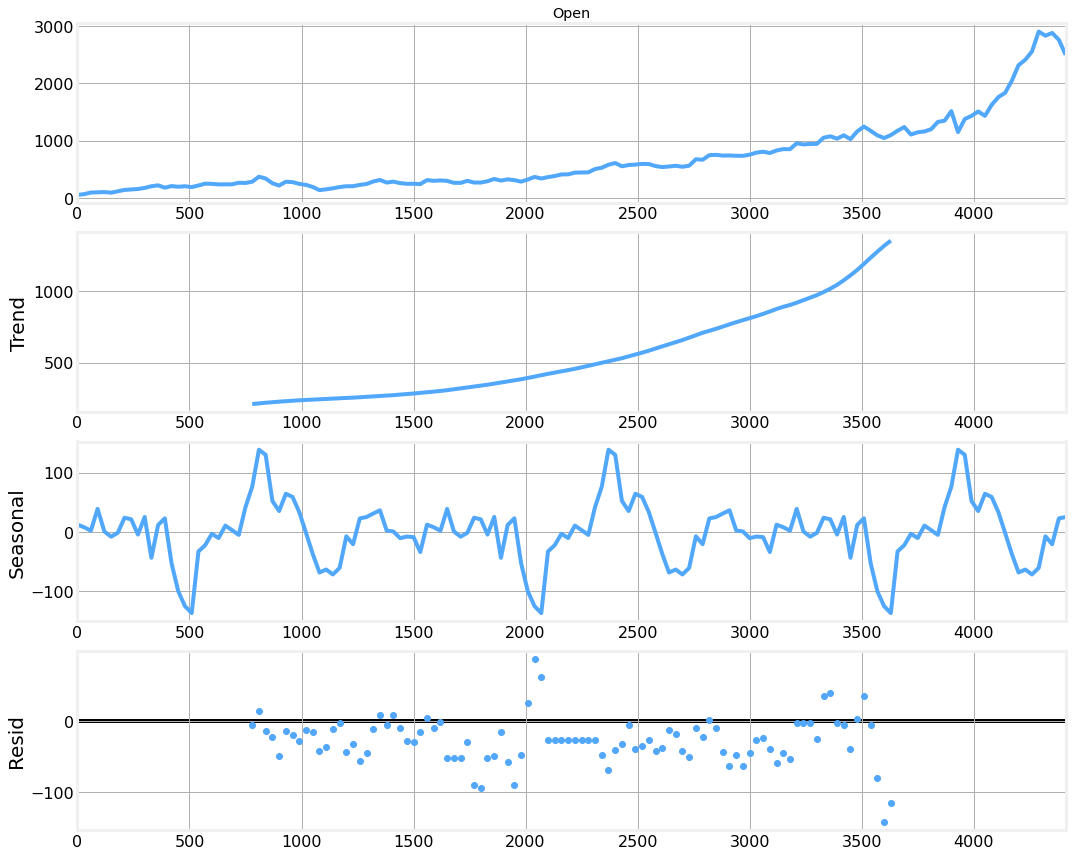

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Open'].iloc[::30],
                                   model='additive',
                                   period = 52)
decomposition.plot()
plt.show()

We have plotted the graph for time series component Trend, Season, Residuals of Open_diff value to check whether seasonal component is stationary or not after difference.

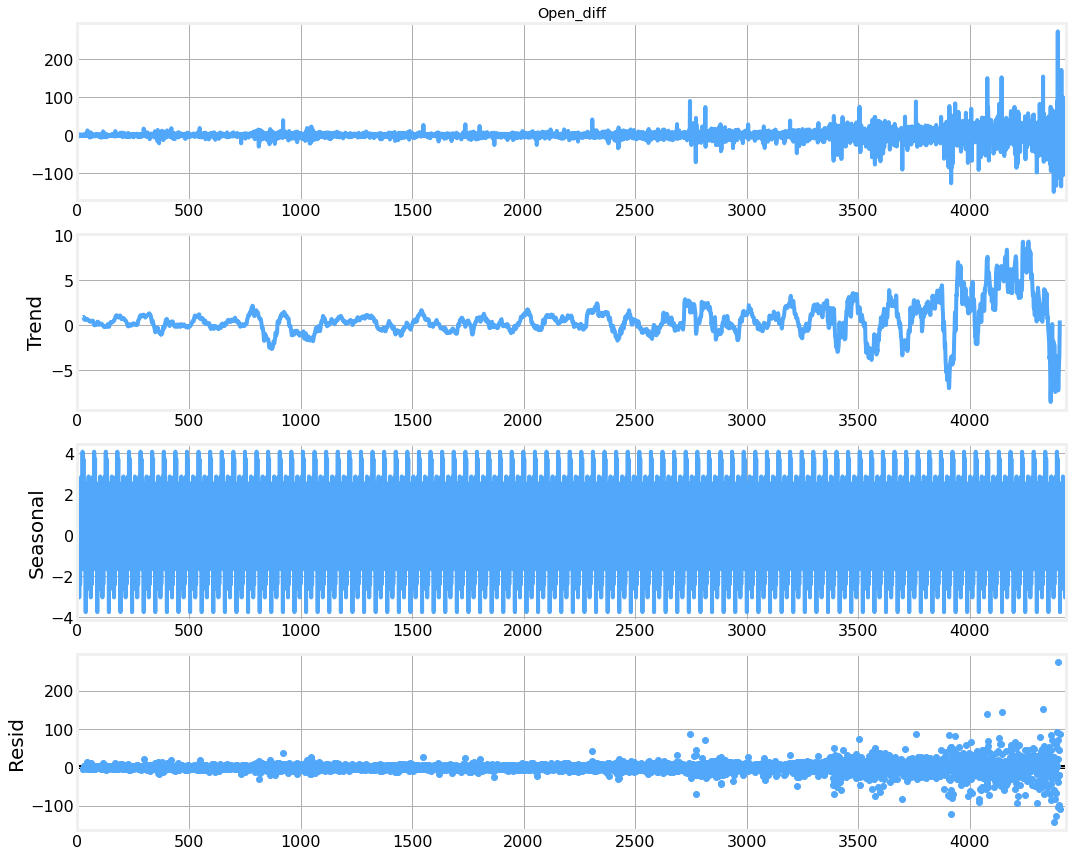

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Open_diff'],
                                   model='additive',
                                   period = 52)
decomposition.plot()
plt.show()

As per the plot, seasonal component is stationary so there is no seasonality in time series

## Auto Correlation Plot

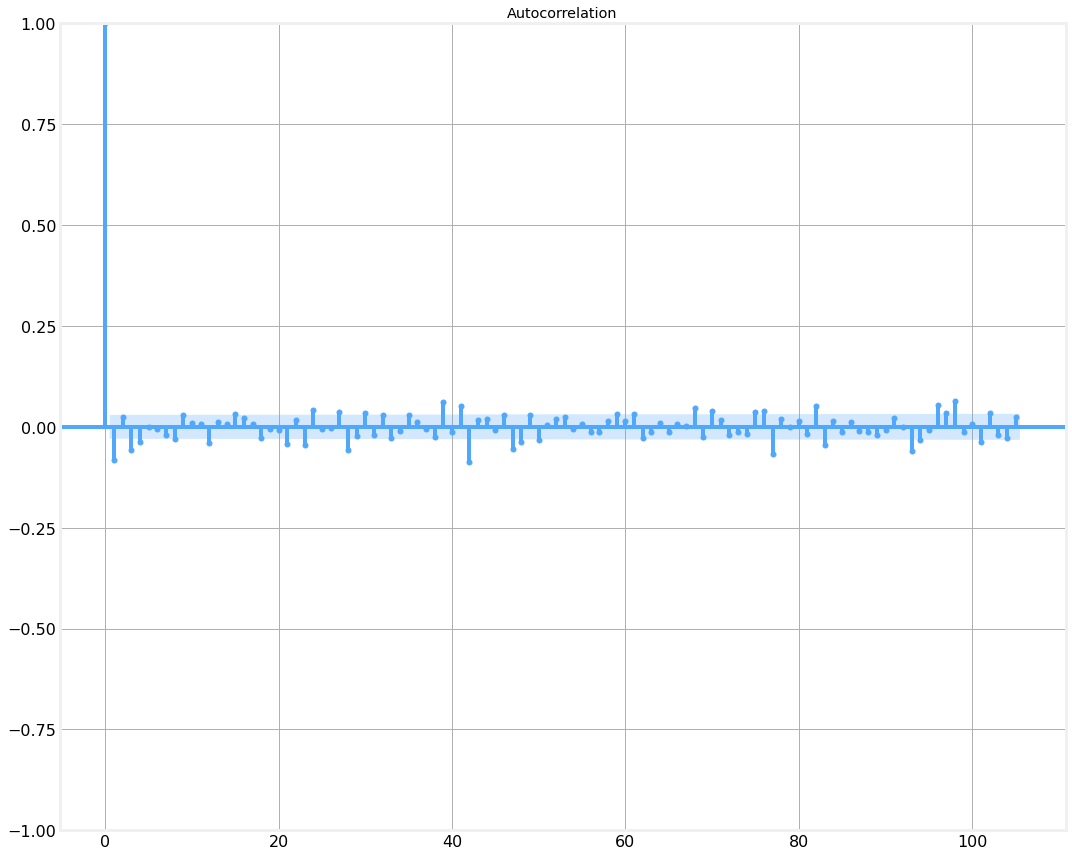

In [20]:
plot_acf(df['Open'].diff(1).dropna(), lags=105);

Skipping the first lag (at 0 on the X-axis), we see that there is one point outside of the blue highlighted region. This means that we have one significant lag.
Thus, we will use q = 1.

## Partial Auto Correlation Plot

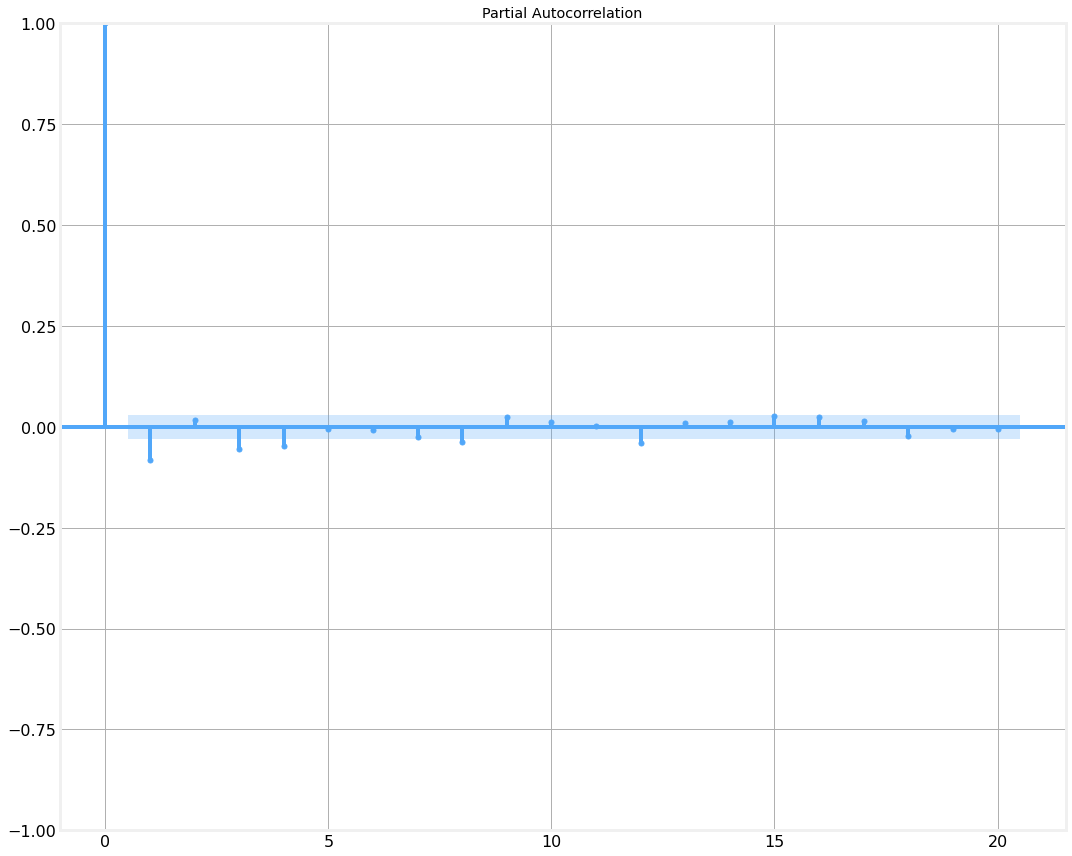

In [21]:
plot_pacf(df['Open'].diff(1).dropna(), lags=20);

Skipping the first lag (at 0 on the X-axis), we see that there is one point outside of the blue highlighted region. This means that we have one significant lag.
Thus, we will use p = 1.

## Split Dataset

In [22]:
copy_df = df[['Open']]

size = int(len(copy_df) * 0.90)

train, test = copy_df[0:size], copy_df[size:len(copy_df)]

print(len(train), len(test))

3987 444


## Time Series Models

#### This univariate time series models we are going to implement for the given series
- AR Model
- MA Model
- ARMA Model
- ARIMA Model
- Auto-ARIMA Model
- Simple Exponential Smooting
- Holt-Winter's Exponential Smooting

### 1. AR (Auto Regressive) Model:
According to Partial Auto Correlation Plot, order of p term for AR model is 1.

In [23]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(train['Open'], lags=1).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   Open   No. Observations:                 3987
Model:                     AutoReg(1)   Log Likelihood              -15120.203
Method:               Conditional MLE   S.D. of innovations             10.744
Date:                Sun, 26 Jun 2022   AIC                          30246.406
Time:                        20:10:48   BIC                          30265.277
Sample:                             1   HQIC                         30253.096
                                 3987                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2695      0.295      0.914      0.361      -0.309       0.848
Open.L1        1.0002      0.000   2159.585      0.000       0.999       1.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9998           +0.0000j            0.9998            0.0000
-----------------------------------------------------------------------------
"""

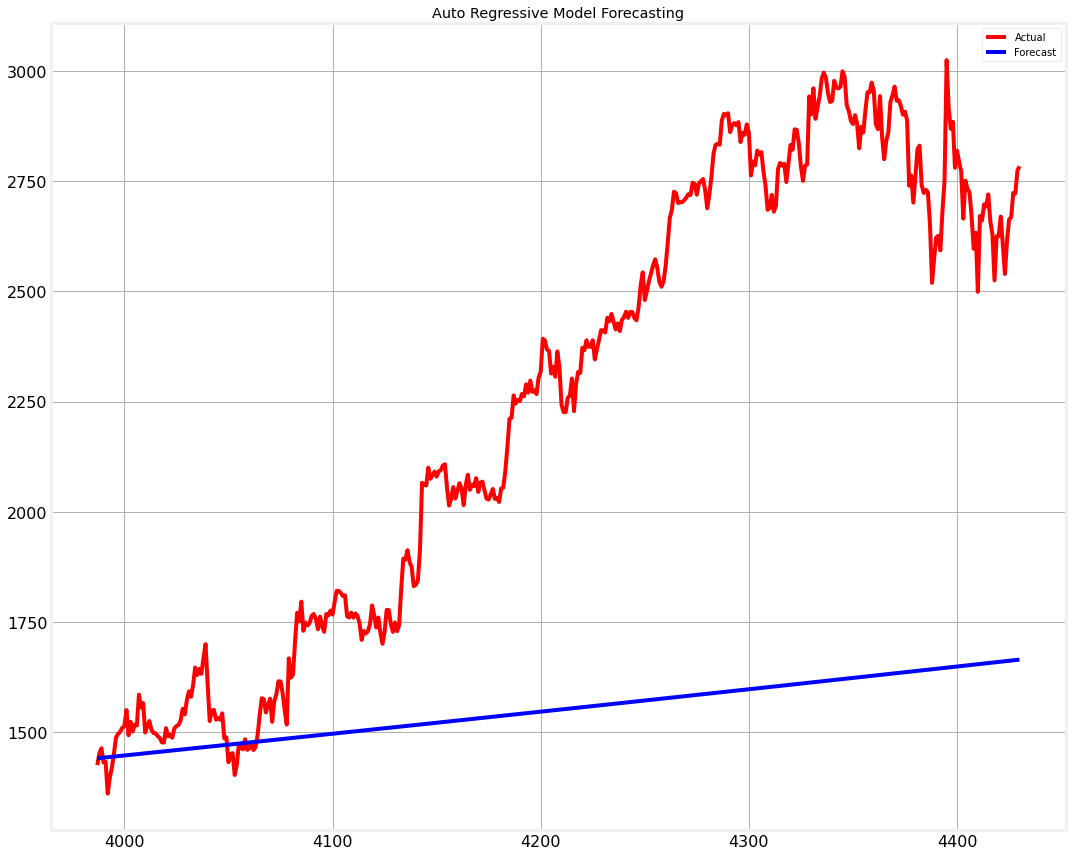

In [24]:
ar_pred = ar_model.predict(start=len(train), end=(len(train) + len(test)-1), dynamic=False)

plt.plot(test, color='red', label = 'Actual')
plt.plot(ar_pred, color = 'blue', label = 'Forecast')
plt.title("Auto Regressive Model Forecasting")
plt.legend()
plt.show()

In [25]:
MAE = mean_absolute_error(test, ar_pred)
MSE = mean_squared_error(test, ar_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(test, ar_pred)

print("Mean Absolute Error:", MAE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)
print("R Squared:", R2)

Mean Absolute Error: 692.7789631072875
Mean Squared Error: 689765.0696627054
Root Mean Squared Error: 830.5209628075052
R Squared: -1.5311243293547685


### 2. MA(Moving Average) Model

According to Auto Correlation Plot, order of q term for MA model is 1.

In [26]:
from statsmodels.tsa.arima.model import ARIMA

ma_model = ARIMA(train, order=(0, 0, 1)).fit()
ma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 3987
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -26518.860
Date:                Sun, 26 Jun 2022   AIC                          53043.720
Time:                        20:10:49   BIC                          53062.592
Sample:                             0   HQIC                         53050.411
                               - 3987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        521.8239      8.223     63.459      0.000     505.707     537.941
ma.L1          0.9847      0.002    412.463      0.000       0.980       0.989
sigma2      3.504e+04   1228.805     28.515      0.000    3.26e+04    3.74e+04
===================================================================================
Ljung-Box (L1) (Q):                3680.81   Jarque-Bera (JB):               549.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

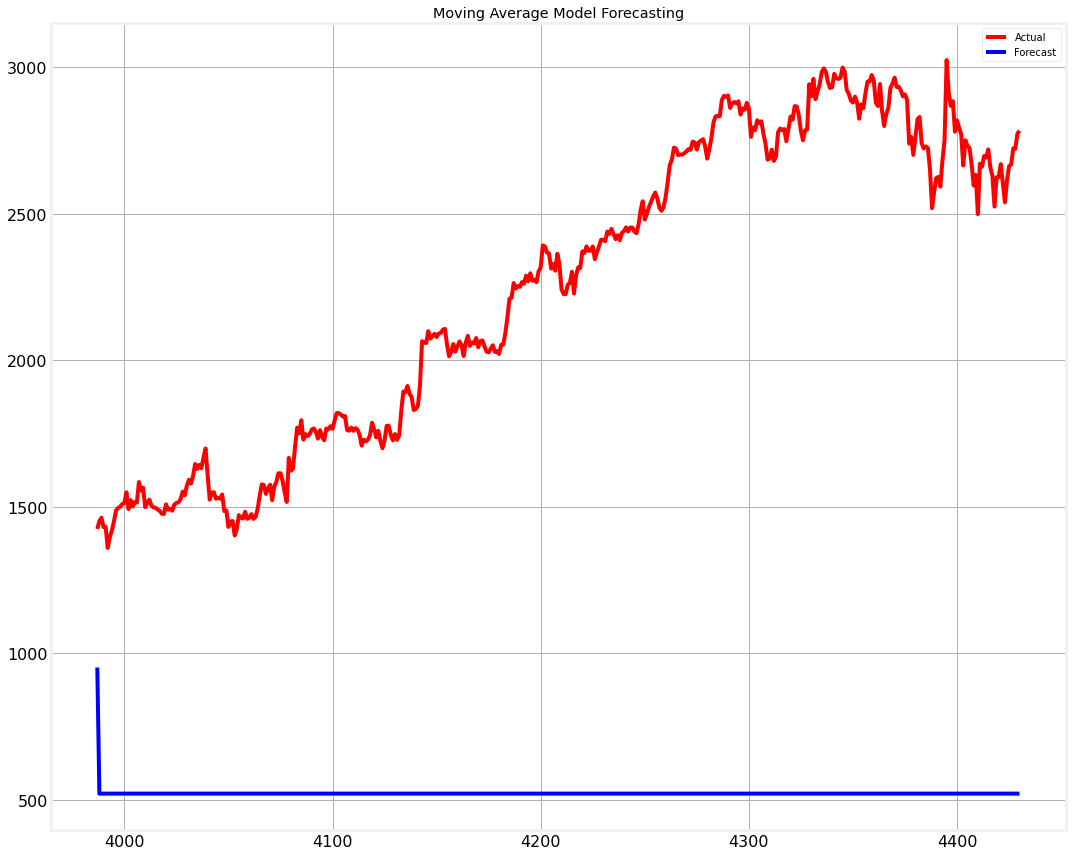

In [27]:
ma_pred = ma_model.predict(start=len(train), end=(len(df)-1), dynamic=False)

plt.plot(test, color='red', label = 'Actual')
plt.plot(ma_pred, color = 'blue', label = 'Forecast')
plt.title("Moving Average Model Forecasting")
plt.legend()
plt.show()

In [28]:
MAE = mean_absolute_error(test, ma_pred)
MSE = mean_squared_error(test, ma_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(test, ma_pred)

print("Mean Absolute Error:", MAE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)
print("R Squared:", R2)

Mean Absolute Error: 1719.0427810254334
Mean Squared Error: 3229621.634704502
Root Mean Squared Error: 1797.1148084372633
R Squared: -10.85124363895151


### 3. ARMA (Auto Regressive Moving Average) Model

In [29]:
model = ARIMA(train['Open'], order = (2,0,2))
arma_model = model.fit()

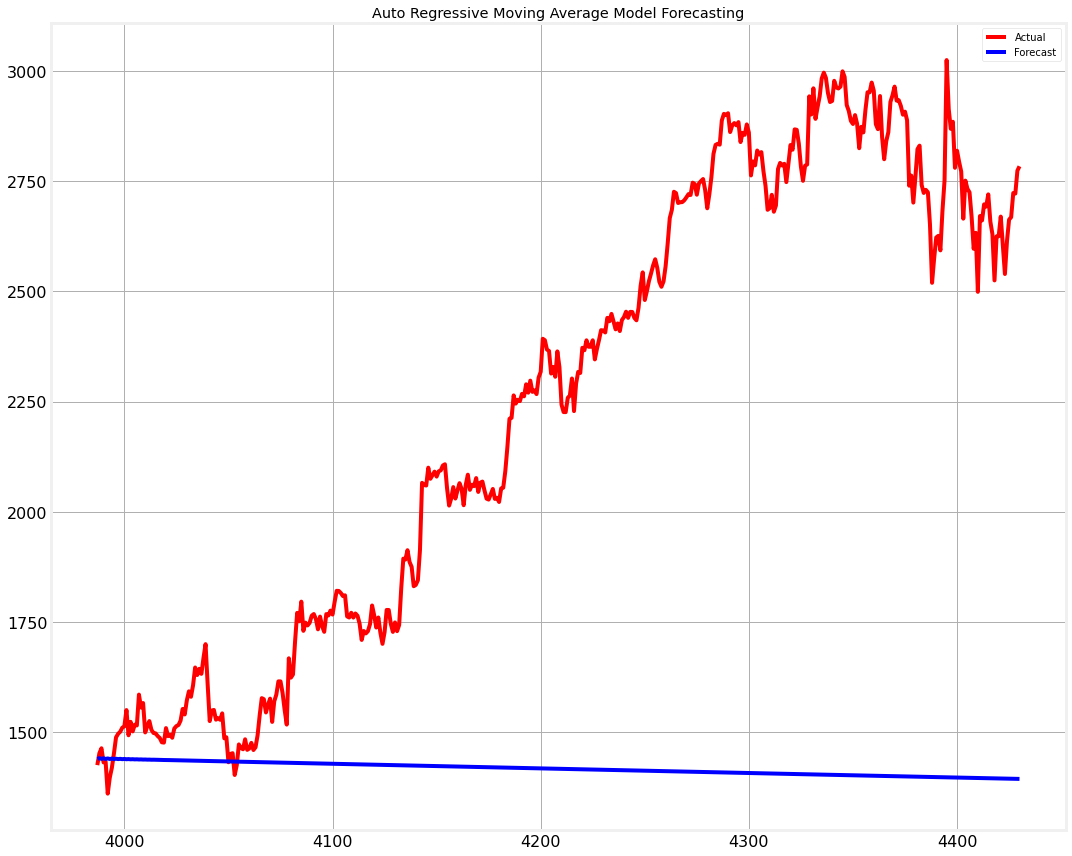

In [30]:
arma_pred = arma_model.predict(start=len(train), end=(len(df)-1), dynamic=False, alpha = 0)

plt.plot(test, color ='red', label = 'Actual')
plt.plot(arma_pred, color = 'blue', label = 'Forecast')
plt.title("Auto Regressive Moving Average Model Forecasting")
plt.legend()
plt.show()

In [31]:
MAE = mean_absolute_error(test, arma_pred)
MSE = mean_squared_error(test, arma_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(test, arma_pred)

print("Mean Absolute Error:", MAE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)
print("R Squared:", R2)

Mean Absolute Error: 826.0738522531162
Mean Squared Error: 966780.1179738705
Root Mean Squared Error: 983.2497739505819
R Squared: -2.547643662119246


### 4. ARIMA Model

In [32]:
model = ARIMA(train, order=(5, 3, 3))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 3987
Model:                 ARIMA(5, 3, 3)   Log Likelihood              -15472.965
Date:                Sun, 26 Jun 2022   AIC                          30963.930
Time:                        20:10:53   BIC                          31020.540
Sample:                             0   HQIC                         30984.001
                               - 3987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3477      0.088    -15.303      0.000      -1.520      -1.175
ar.L2         -0.8231      0.064    -12.796      0.000      -0.949      -0.697
ar.L3         -0.7492      0.055    -13.606      0.000      -0.857      -0.641
ar.L4         -0.5659      0.046    -12.367      0.000      -0.656      -0.476
ar.L5         -0.2059      0.028     -7.299      0.000      -0.261      -0.151
ma.L1         -0.4909      0.088     -5.577      0.000      -0.663      -0.318
ma.L2         -0.8732      0.106     -8.245      0.000      -1.081      -0.666
ma.L3          0.3649      0.032     11.477      0.000       0.303       0.427
sigma2       155.6400      1.543    100.851      0.000     152.615     158.665
===================================================================================
Ljung-Box (L1) (Q):                  41.18   Jarque-Bera (JB):             49054.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.29   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

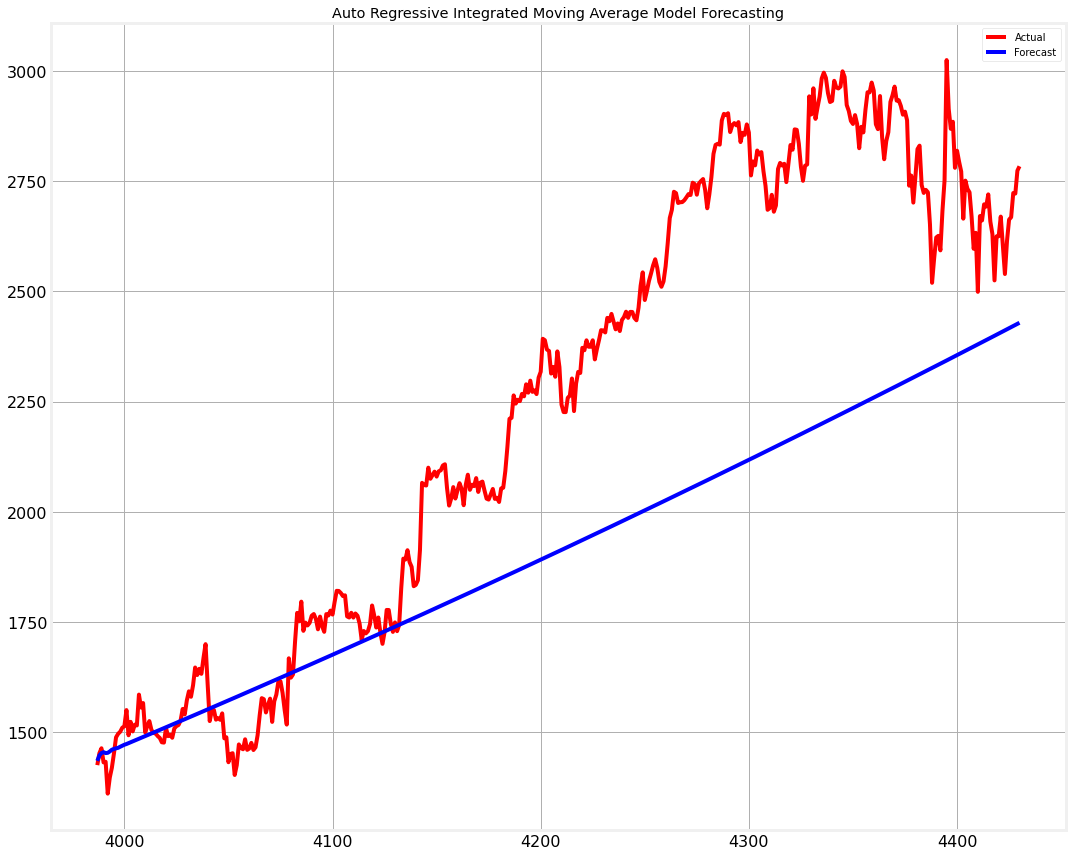

In [33]:
arima_pred = model_fit.predict(start=len(train), end=(len(df)-1), dynamic=False)

plt.plot(test, color ='red', label = 'Actual')
plt.plot(arima_pred, color = 'blue', label = 'Forecast')
plt.title("Auto Regressive Integrated Moving Average Model Forecasting")
plt.legend()
plt.show()

In [34]:
MAE = mean_absolute_error(test, arima_pred)
MSE = mean_squared_error(test, arima_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(test, arima_pred)

print("Mean Absolute Error:", MAE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)
print("R Squared:", R2)

Mean Absolute Error: 338.4243511274503
Mean Squared Error: 177924.7985074022
Root Mean Squared Error: 421.81133046351687
R Squared: 0.3470968506453198


### 5. Auto ARIMA

In [35]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [36]:
from pmdarima import auto_arima 

stepwise_fit = auto_arima(df['Open'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=40865.476, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=39277.349, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=38839.822, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=38572.234, Time=0.19 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=38333.960, Time=0.28 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=38182.202, Time=0.31 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.48 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.05 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=38184.196, Time=0.42 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 4.630 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4431
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -19085.101
Date:                Sun, 26 Jun 2022   AIC                          38182.202
Time:                        20:10:59   BIC                          38220.578
Sample:                             0   HQIC                         38195.735
                               - 4431                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8912      0.005   -183.127      0.000      -0.901      -0.882
ar.L2         -0.6712      0.007    -93.805      0.000      -0.685      -0.657
ar.L3         -0.5347      0.007    -80.584      0.000      -0.548      -0.522
ar.L4         -0.3865      0.008    -47.045      0.000      -0.403      -0.370
ar.L5         -0.1848      0.007    -28.222      0.000      -0.198      -0.172
sigma2       324.1476      1.975    164.123      0.000     320.277     328.019
===================================================================================
Ljung-Box (L1) (Q):                   3.09   Jarque-Bera (JB):            119124.55
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):              32.56   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
auto_model = ARIMA(train,order=(5,2,0) )
auto_model = auto_model.fit()
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 3987
Model:                 ARIMA(5, 2, 0)   Log Likelihood              -15426.964
Date:                Sun, 26 Jun 2022   AIC                          30865.928
Time:                        20:10:59   BIC                          30903.670
Sample:                             0   HQIC                         30879.309
                               - 3987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9037      0.006   -150.331      0.000      -0.915      -0.892
ar.L2         -0.7125      0.009    -80.930      0.000      -0.730      -0.695
ar.L3         -0.5040      0.010    -49.359      0.000      -0.524      -0.484
ar.L4         -0.3632      0.010    -38.100      0.000      -0.382      -0.344
ar.L5         -0.1682      0.007    -23.786      0.000      -0.182      -0.154
sigma2       134.8742      1.030    130.971      0.000     132.856     136.893
===================================================================================
Ljung-Box (L1) (Q):                   4.03   Jarque-Bera (JB):             43440.36
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):              12.38   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

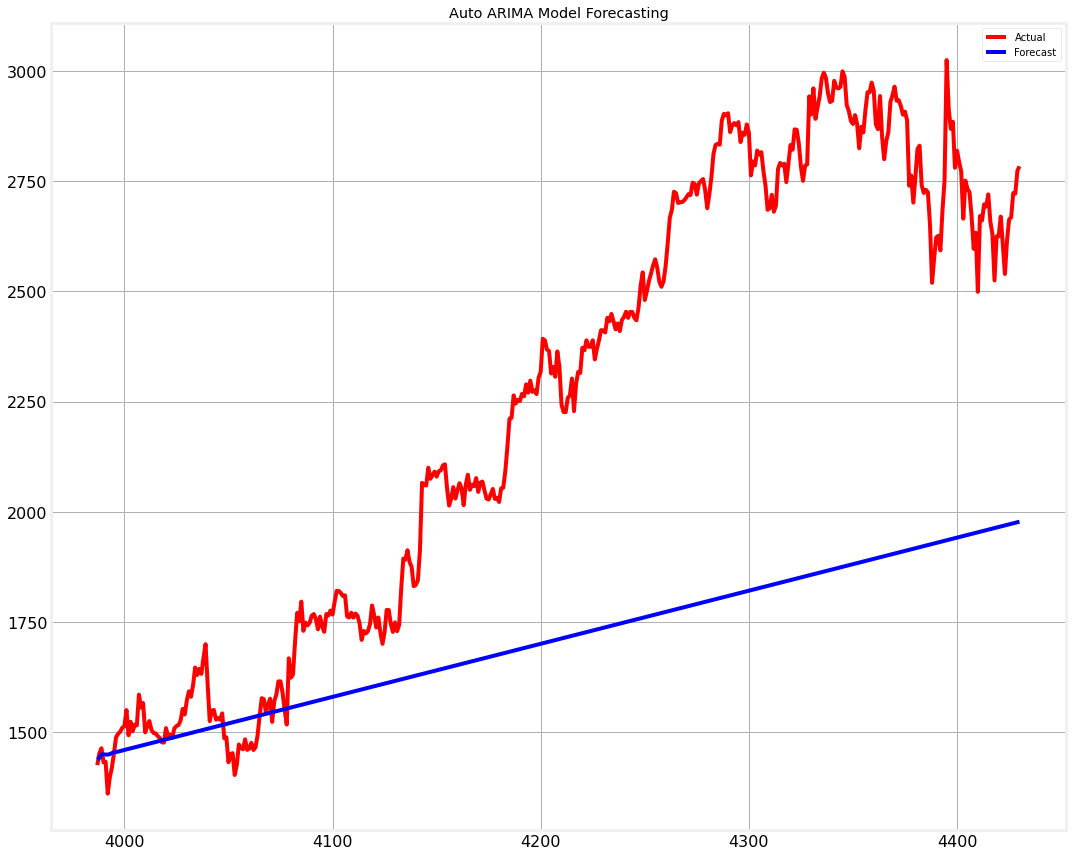

In [38]:
auto_pred = auto_model.predict(start=len(train), end=(len(df)-1), typ='levels')

plt.plot(test, color ='red', label = 'Actual')
plt.plot(auto_pred, color = 'blue', label = 'Forecast')
plt.title("Auto ARIMA Model Forecasting")
plt.legend()
plt.show()

In [39]:
MAE = mean_absolute_error(test, auto_pred)
MSE = mean_squared_error(test, auto_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(test, auto_pred)

print("Mean Absolute Error:", MAE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)
print("R Squared:", R2)

Mean Absolute Error: 537.6490020546744
Mean Squared Error: 426047.58884201315
Root Mean Squared Error: 652.7232099764901
R Squared: -0.5634010259584228


### 6. Simple Exponential Smoothing

<AxesSubplot:title={'center':'Exponential Smoothing'}>

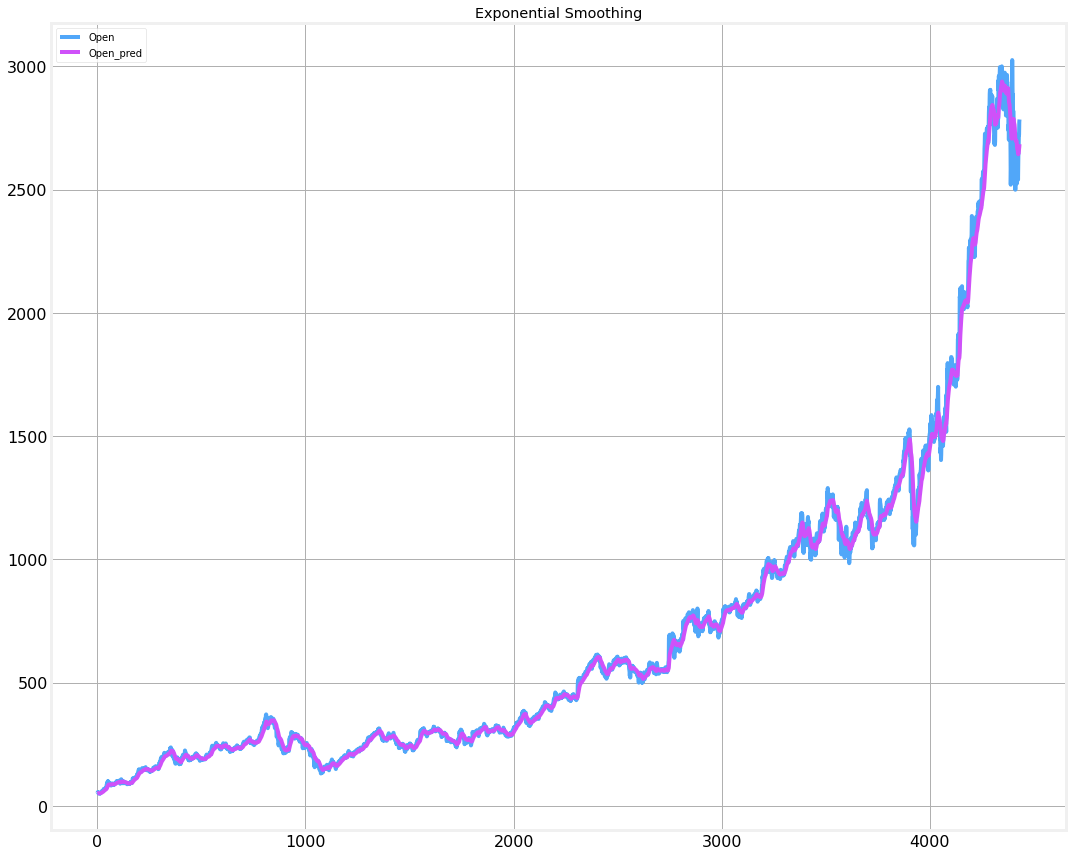

In [40]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

alpha = 0.1
es = []
es.append(df.at[0,'Open'])

def exponetial_smooting(x):
    zt = alpha * df.at[x,'Open'] + (1 - alpha) * es[x-1]
    es.append(round(zt, 1))
    
for i in range(1,len(df)):
    exponetial_smooting(i)

df['Open_pred'] = es

df[['Open','Open_pred']].plot(title = 'Exponential Smoothing')

### 7. Holt Winter's Exponential Smoothing

Text(0.5, 1.0, 'Holt Winters Triple Exponential Smoothing')

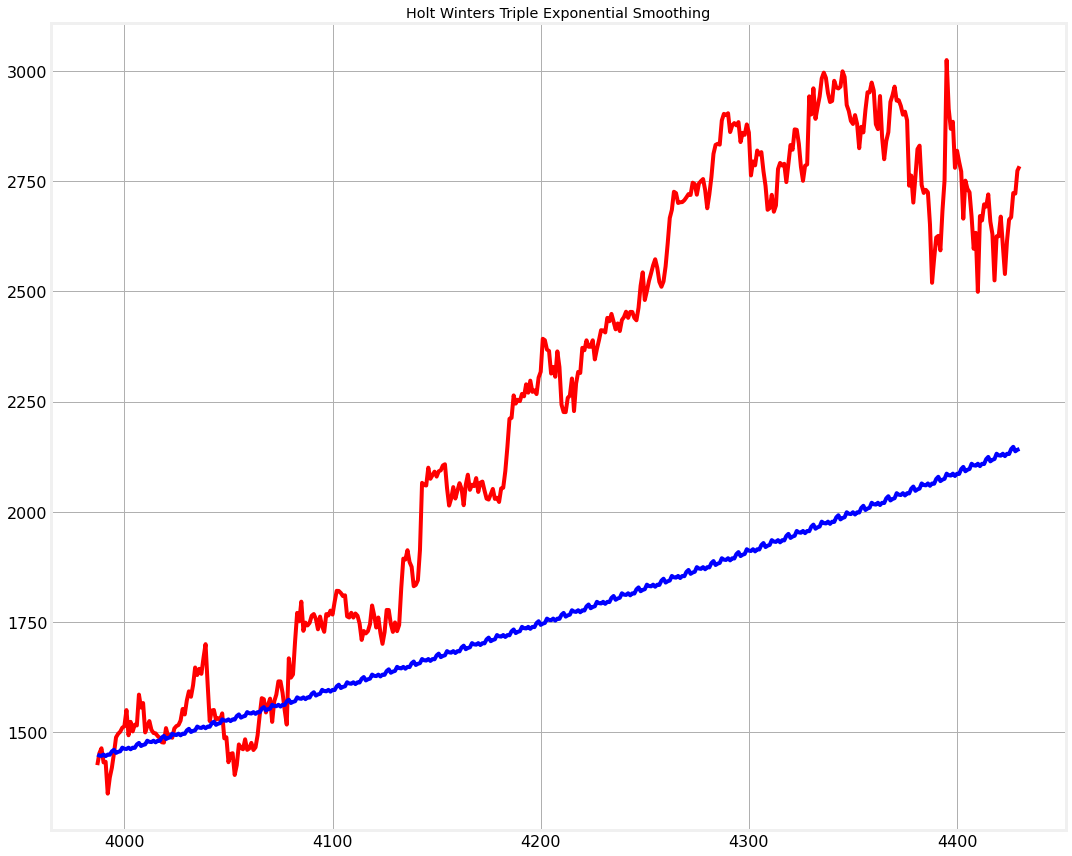

In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train['Open'], trend = 'mul', seasonal = 'mul', seasonal_periods = 12).fit()

hw_pred = model.forecast(len(test))
plt.plot(test, color = 'red', label = 'Actual')
plt.plot(hw_pred, color = 'blue', label = 'Forecast')
plt.title('Holt Winters Triple Exponential Smoothing')

In [42]:
MAE = mean_absolute_error(test, hw_pred)
MSE = mean_squared_error(test, hw_pred)
RMSE = math.sqrt(MSE)
R2 = r2_score(test, hw_pred)

print("Mean Absolute Error:", MAE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)
print("R Squared:", R2)

Mean Absolute Error: 477.6993834523344
Mean Squared Error: 336528.6227645655
Root Mean Squared Error: 580.1108710966944
R Squared: -0.2349071039798698


### 8. Recurrent Neural Network (RNN)

In [43]:
df_train = pd.read_csv('Google_train.csv',parse_dates=True)

In [44]:
training_set=df['Open']
training_set=pd.DataFrame(training_set)

In [45]:
dataset_test = pd.read_csv('Google_test_with_anomaly.csv',index_col="Date",parse_dates=True)

In [46]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [47]:
# Creating a structure with 60 timesteps abd a output based on 60 data values
X_train = []
y_train = []
for i in range(60, 4131):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train : ",X_train)
print("y_train : ",y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train :  [[1.36253641e-04 3.06152003e-04 1.94456941e-03 ... 1.26010132e-02
  1.20240333e-02 1.17649829e-02]
 [3.06152003e-04 1.94456941e-03 2.02699418e-03 ... 1.20240333e-02
  1.17649829e-02 1.44732507e-02]
 [1.94456941e-03 2.02699418e-03 9.70602048e-04 ... 1.17649829e-02
  1.44732507e-02 1.36691804e-02]
 ...
 [5.02412376e-01 5.08236876e-01 5.12975839e-01 ... 5.63668928e-01
  5.80608090e-01 5.80561032e-01]
 [5.08236876e-01 5.12975839e-01 4.95223314e-01 ... 5.80608090e-01
  5.80561032e-01 5.69920274e-01]
 [5.12975839e-01 4.95223314e-01 5.10932359e-01 ... 5.80561032e-01
  5.69920274e-01 5.63857120e-01]]
y_train :  [0.01447325 0.01366918 0.01317294 ... 0.56992027 0.56385712 0.57109997]


**Part 2 - Building the RNN**

In [48]:
# Importing the libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [49]:
# Initialise the basic neural network(Sequential)
regressor = Sequential()

Metal device set to: Apple M1


2022-06-26 20:11:04.440277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-26 20:11:04.440526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [50]:
# First layer with 20% dropout
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Second layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Third layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Fourth layer
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the final output layer
regressor.add(Dense(units = 1))

In [51]:
# Compiling RNN with "ADAM" optimizer
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set of the data
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100


2022-06-26 20:11:04.872542: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-26 20:11:06.133333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:11:06.505712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:11:06.621906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:11:06.708022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:11:06.800421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:11:06.943768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

128/128 [==============================] - 10s 56ms/step - loss: 0.0021
Epoch 2/100
128/128 [==============================] - 7s 52ms/step - loss: 2.7246e-04
Epoch 3/100
128/128 [==============================] - 7s 52ms/step - loss: 2.2894e-04
Epoch 4/100
128/128 [==============================] - 7s 51ms/step - loss: 1.7314e-04
Epoch 5/100
128/128 [==============================] - 7s 53ms/step - loss: 1.6791e-04
Epoch 6/100
128/128 [==============================] - 7s 52ms/step - loss: 1.6695e-04
Epoch 7/100
128/128 [==============================] - 7s 52ms/step - loss: 1.5289e-04
Epoch 8/100
128/128 [==============================] - 7s 54ms/step - loss: 1.4558e-04
Epoch 9/100
128/128 [==============================] - 7s 54ms/step - loss: 1.2979e-04
Epoch 10/100
128/128 [==============================] - 7s 52ms/step - loss: 1.9844e-04
Epoch 11/100
128/128 [==============================] - 7s 53ms/step - loss: 1.3960e-04
Epoch 12/100
128/128 [==============================] - 

In [52]:
# Getting the real values of the data
real_stock_price = dataset_test.iloc[:, 1:2].values
len(real_stock_price)

300

In [53]:
dataset_test

Unnamed: 0         Open         High          Low        Close  \
Date                                                                         
2021-01-15           0  1729.020020  1747.619995  1711.709961  1727.619995   
2021-01-19           1  1743.000000  1803.839966  1732.829956  1784.469971   
2021-01-20           2  1826.369995  1899.719971  1819.510010  1880.069946   
2021-01-21           3  1893.650024  1932.079956  1879.410034  1884.150024   
2021-01-22           4  1891.459961  1904.390015  1876.500000  1892.560059   
...                ...          ...          ...          ...          ...   
2022-03-18         295  2668.489990  2724.879883  2645.169922  2722.510010   
2022-03-21         296  2723.270020  2741.000000  2681.850098  2722.030029   
2022-03-22         297  2722.030029  2821.000000  2722.030029  2797.360107   
2022-03-23         298  2774.050049  2791.770020  2756.699951  2765.510010   
2022-03-24         299  2784.000000  2832.379883  2755.010010  2831.439941   

              Adj Close   Volume  
Date                              
2021-01-15  1727.619995  1572200  
2021-01-19  1784.469971  2083000  
2021-01-20  1880.069946  3207600  
2021-01-21  1884.150024  2931700  
2021-01-22  1892.560059  1637200  
...                 ...      ...  
2022-03-18  2722.510010  2223100  
2022-03-21  2722.030029  1341600  
2022-03-22  2797.360107  1774800  
2022-03-23  2765.510010  1257700  
2022-03-24  2831.439941  1317900  

[300 rows x 7 columns]

In [54]:
test_set=dataset_test['Open']
test_set=pd.DataFrame(test_set)
len(test_set)

300

In [55]:
# Getting the predicted stock price from our model

dataset_total = pd.concat((test['Open'], test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 300):
    X_test.append(inputs[i-60:i, 0])

print("Len :", len(X_test))
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = regressor.predict(X_test)

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Len : 240


2022-06-26 20:22:45.534113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:22:45.677626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:22:45.848250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:22:45.925723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 20:22:46.010031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [56]:
predicted_stock_price=pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       240 non-null    float32
dtypes: float32(1)
memory usage: 1.1 KB


In [57]:
len(predicted_stock_price)

240

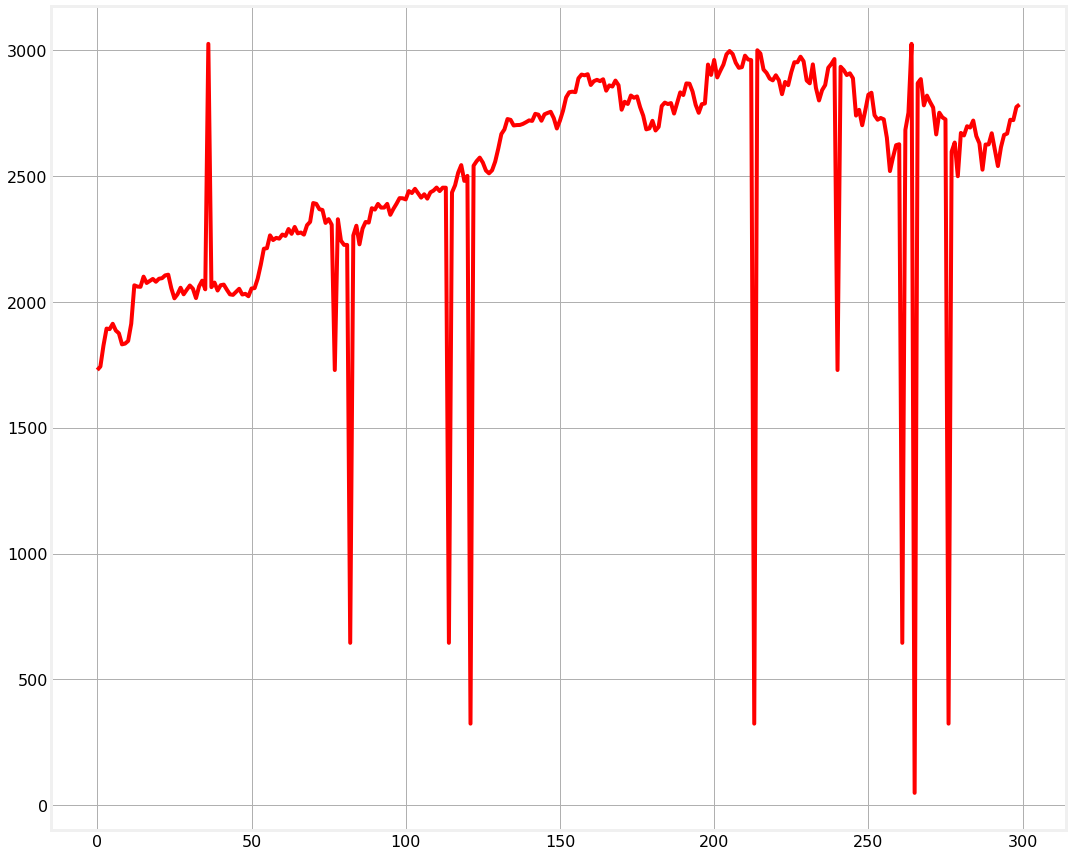

In [58]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')

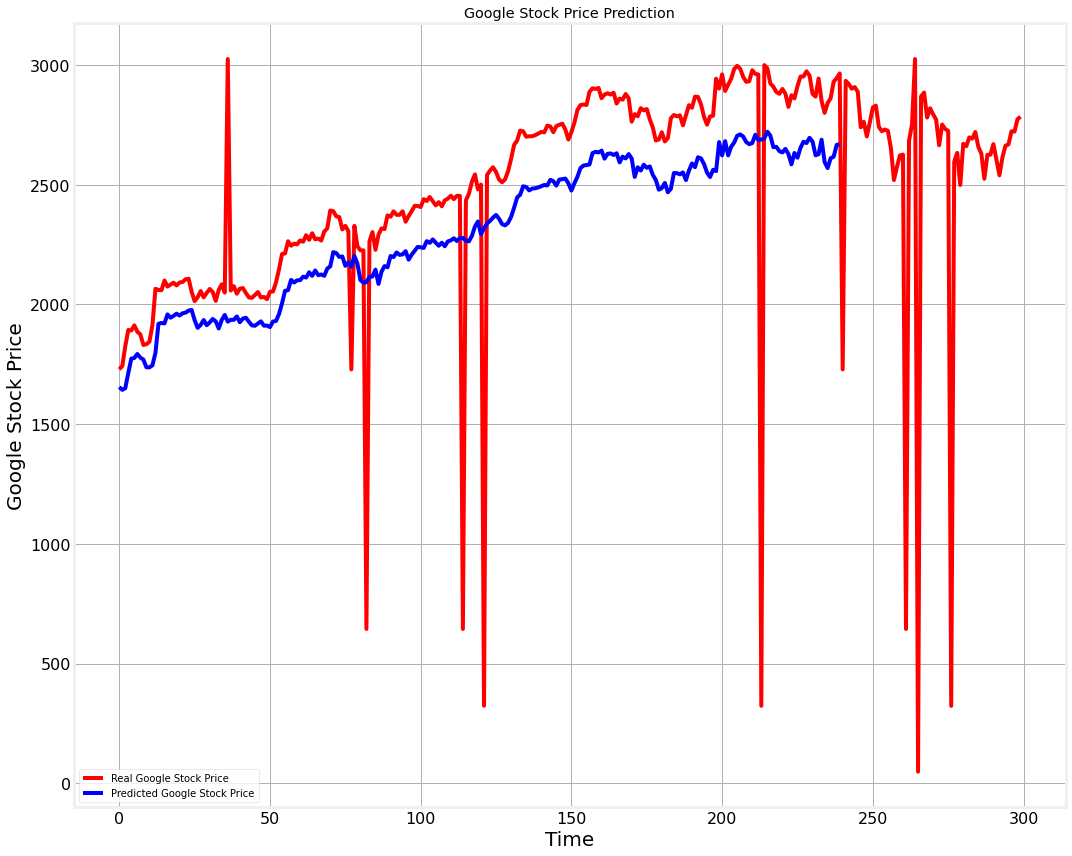

In [59]:
# Visualising the results of Actual price vs predicted price

plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [60]:
temp_df = predicted_stock_price
temp_df.columns = ["Open"]

temp_df

Open
0    1655.063721
1    1643.375732
2    1650.643066
3    1714.537231
4    1773.723511
..           ...
235  2569.608887
236  2610.753662
237  2616.925049
238  2666.411377
239  2668.881836

[240 rows x 1 columns]

In [61]:
lst = list(predicted_stock_price['Open'])
real_stock_price_lst = real_stock_price.flatten().tolist()

In [62]:
difference = []
for i in range(len(predicted_stock_price)):
    difference.append(abs(real_stock_price_lst[i] - lst[i]))
lst_2 = sorted(difference, key=float)
print(lst_2[-5:])
print("Anomalies Found :", len(lst_2[-5:]))

[1096.6212158203125, 1447.903076171875, 1632.700927734375, 1993.41064453125, 2364.846435546875]
Anomalies Found : 5


## 9. Prophet

In [63]:
df = pd.read_csv('Google_train.csv',parse_dates=True)

df.drop(["High", "Low", "Close", "Volume", "Adj Close"], axis=1, inplace=True)
df.head()

Date       Open
0  2004-08-19  50.050049
1  2004-08-20  50.555557
2  2004-08-23  55.430431
3  2004-08-24  55.675674
4  2004-08-25  52.532532

In [64]:
df.columns = ["ds", "y"]

In [65]:
!pip install fbprophet

In [66]:
from fbprophet import Prophet

In [67]:
model = Prophet()

In [68]:
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Initial log joint probability = -98.1837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       12087.8    0.00738753       823.716      0.7964      0.7964      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       12186.8   0.000737706       401.332           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       12212.9     0.0208422       1838.98           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       12235.7   0.000465613       142.474           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       12242.9    0.00468064       1117.68      0.3313      0.3313      578   
    Iter      log

   1599       12267.1    0.00752668       238.131           1           1     2002   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699       12267.3   0.000372186       135.364      0.2763      0.2763     2131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1701       12267.3   8.98757e-06       55.7635   7.391e-08       0.001     2178  LS failed, Hessian reset 
    1732       12267.4   8.92503e-06       78.5237   1.408e-07       0.001     2264  LS failed, Hessian reset 
    1757       12267.4   2.15373e-06       53.1457      0.5851      0.5851     2296   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [69]:
model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [70]:
prediction_dates = model.make_future_dataframe(periods= 400)

In [71]:
prediction_dates.tail()

ds
4526 2022-02-14
4527 2022-02-15
4528 2022-02-16
4529 2022-02-17
4530 2022-02-18

In [72]:
prediction = model.predict(prediction_dates)

In [73]:
prediction.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2004-08-19  54.893773  -11.941793  128.503119    54.893773    54.893773   
1 2004-08-20  55.151020  -12.541342  130.693915    55.151020    55.151020   
2 2004-08-23  55.922761  -15.729714  129.808859    55.922761    55.922761   
3 2004-08-24  56.180008  -12.976617  127.034138    56.180008    56.180008   
4 2004-08-25  56.437255  -15.093815  125.457100    56.437255    56.437255   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        3.270105              3.270105              3.270105  1.595389   
1        2.625661              2.625661              2.625661  0.993757   
2        1.744965              1.744965              1.744965  0.188017   
3        2.469176              2.469176              2.469176  0.942723   
4        2.869408              2.869408              2.869408  1.386877   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      1.595389      1.595389  1.674716      1.674716      1.674716   
1      0.993757      0.993757  1.631904      1.631904      1.631904   
2      0.188017      0.188017  1.556949      1.556949      1.556949   
3      0.942723      0.942723  1.526453      1.526453      1.526453   
4      1.386877      1.386877  1.482530      1.482530      1.482530   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  58.163878  
1                         0.0  57.776681  
2                         0.0  57.667726  
3                         0.0  58.649184  
4                         0.0  59.306662

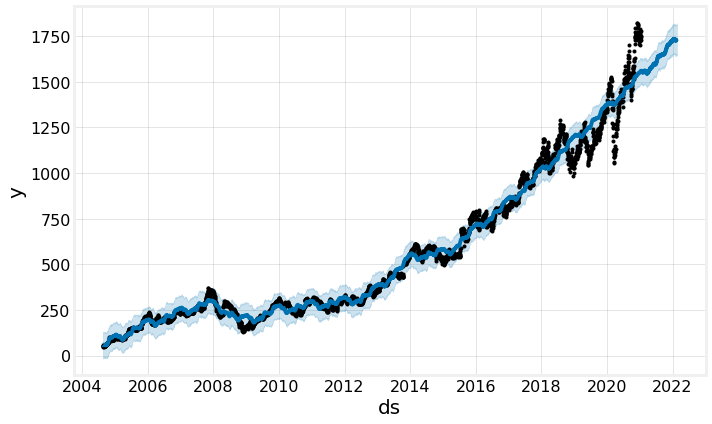

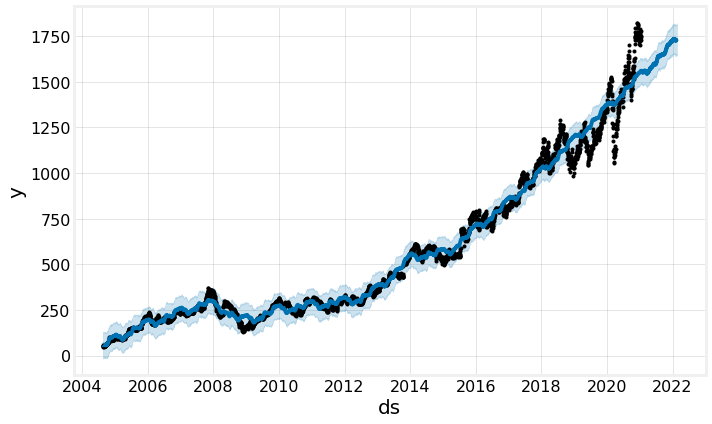

In [74]:
model.plot(prediction)

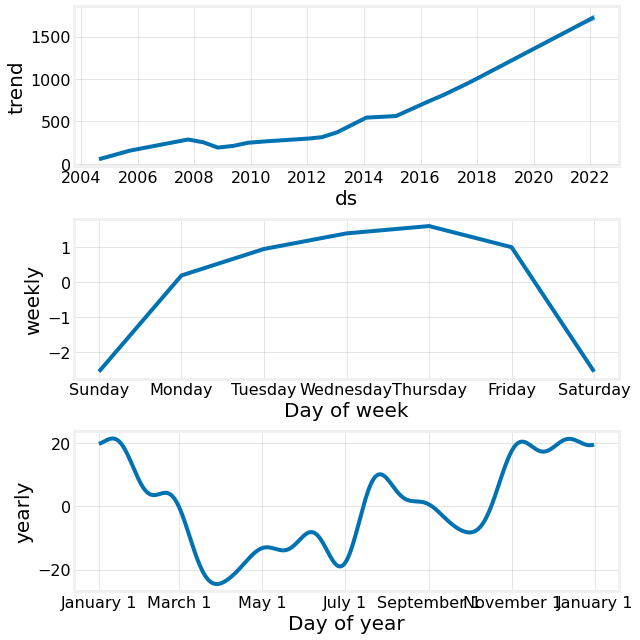

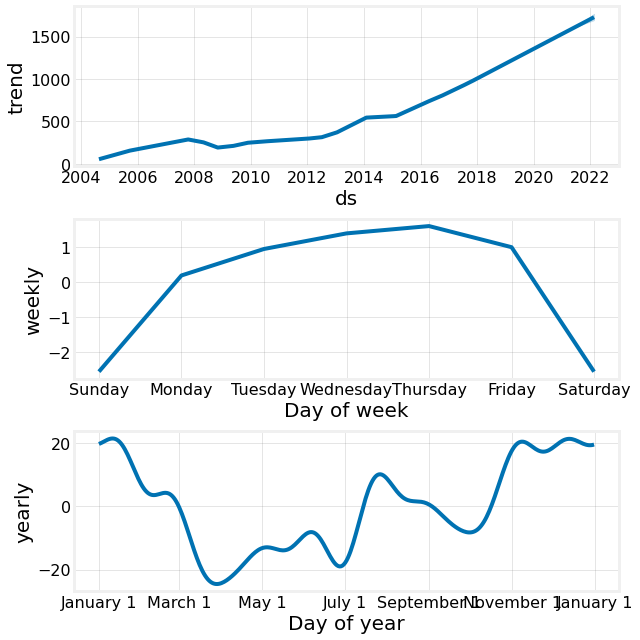

In [75]:
model.plot_components(prediction)

In [76]:
from fbprophet.diagnostics import cross_validation

df_cross_validation = cross_validation(model, initial = "1000 days", period="182 days", horizon="365 days")

INFO:fbprophet:Making 26 forecasts with cutoffs between 2007-08-01 00:00:00 and 2020-01-15 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

Initial log joint probability = -6.10668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2283.38     0.0110158       1069.79      0.3053           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       2293.91   6.47102e-05       125.235   3.726e-07       0.001      226  LS failed, Hessian reset 
     163       2296.58   0.000552138       352.577    5.74e-06       0.001      281  LS failed, Hessian reset 
     199       2299.37     0.0651433       1297.98           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2304.31   0.000278361       363.123     0.09587    0.009587      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2306.19   4.91879e-05       116.362      0.8091      0.8091      575   
    Iter      log pro

Initial log joint probability = -34.7148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2759.53     0.0127436       338.282           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2790.81     0.0172421       252.998           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2798.3    0.00159888       113.814           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       2804.52    0.00036963       205.353   9.725e-07       0.001      505  LS failed, Hessian reset 
     399        2808.4    0.00177134       111.142      0.5331      0.5331      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2811.25   0.000227468    

Initial log joint probability = -29.1152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3602.98     0.0526513        892.98      0.8225      0.8225      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3748.93     0.0360412       988.731     0.09457      0.8241      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3821.43     0.0169627       173.719           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3858.02     0.0373295       1477.64           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3874.15      0.012575       148.205           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -41.0122
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4380.88    0.00868454       762.246           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4570.28     0.0972156       548.069           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4654.92      0.110634       864.844           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4692.33     0.0190044       403.873           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4733.53     0.0028864       425.398      0.8409      0.8409      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -27.0516
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5265.02     0.0323057       711.458           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5380.85     0.0269367       1103.05           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5541.11     0.0312318       678.583      0.3039           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     332       5546.72   4.28907e-05       90.2665   3.884e-07       0.001      434  LS failed, Hessian reset 
     399       5550.85     0.0175223       105.478           1           1      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       5552.64   0.000245915    

Initial log joint probability = -35.6581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6467.5     0.0194081       4935.81      0.4104      0.4104      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6725.93     0.0251917       1124.14           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6843.39    0.00732954       255.366           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6871.45     0.0044518       128.848           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6912.17    0.00277064       742.581      0.3323           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -40.0524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6866.04      0.139437       4900.51           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7086.81     0.0263528       1312.43      0.1847           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7149.78     0.0155422       721.731           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7170.18    0.00368012       131.296           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7176.55    0.00334272       283.511       1.265      0.1265      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -38.7205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8248.13     0.0973434       4296.17           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8439.47       0.13426       2982.07           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        8556.4     0.0161573       1248.72           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8608.26   0.000628346       292.132      0.9006      0.9006      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8627.26    0.00410417       169.063           1           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -75.2932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9931.04     0.0816429       9060.67           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10292.1     0.0102366       1291.84           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10386.1     0.0178082       2422.86           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10492.4    0.00947808       2934.54      0.5071      0.5071      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10536.1     0.0160471       1696.27           1           1      578   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -35.239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10535.8      0.104686       4017.47           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10732.4    0.00516871       2666.14           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10841.6     0.0008874       1202.64      0.5375      0.5375      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10884.8     0.0217717       1848.95           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10924.8    0.00276254       1555.98       0.889       0.889      562   
    Iter      log prob        ||dx||      ||grad||       alpha   

Initial log joint probability = -79.9284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       11448.9     0.0220876       4311.24      0.2807           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       11662.1     0.0123294       1430.64           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       11718.1    0.00305362       1888.48       0.153       0.153      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         11751    0.00154748       277.295      0.6112      0.6112      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       11792.1    0.00260492       622.197           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [77]:
from fbprophet.diagnostics import performance_metrics

df_performance = performance_metrics(df_cross_validation)
df_performance.head()

horizon          mse       rmse        mae      mape     mdape  coverage
0 36 days  4336.866586  65.854890  50.850915  0.103829  0.083400  0.328864
1 37 days  4379.928854  66.181031  51.159571  0.105126  0.083400  0.326394
2 40 days  4411.018496  66.415499  51.497435  0.105931  0.083337  0.326159
3 41 days  4469.168996  66.851844  52.000066  0.107241  0.083896  0.325218
4 42 days  4433.132431  66.581773  51.996755  0.108157  0.083582  0.323747

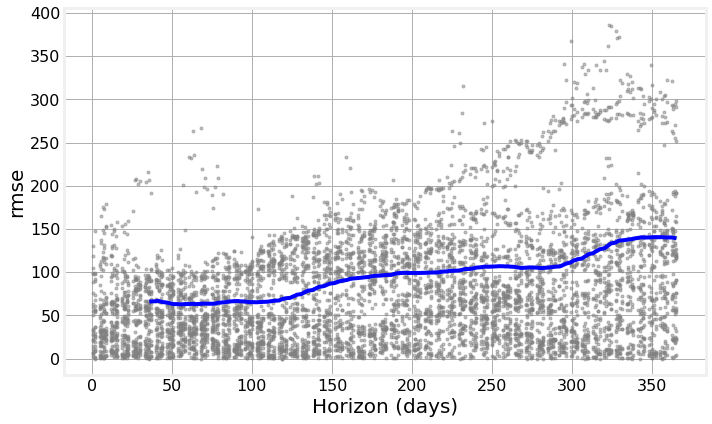

In [78]:
from fbprophet import plot
from fbprophet.plot import plot_cross_validation_metric

figure = plot_cross_validation_metric(df_cross_validation, metric= 'rmse')

In [79]:
prediction.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
4526 2022-02-14  1727.566766  1653.374908  1812.718314  1691.692311   
4527 2022-02-15  1728.045531  1643.997035  1813.233014  1692.070821   
4528 2022-02-16  1728.524296  1651.963782  1816.688483  1692.453056   
4529 2022-02-17  1729.003061  1649.463204  1820.876995  1692.792042   
4530 2022-02-18  1729.481825  1654.873855  1820.113164  1693.129329   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
4526  1768.548764        4.003987              4.003987              4.003987   
4527  1769.144749        4.886363              4.886363              4.886363   
4528  1769.740734        5.455935              5.455935              5.455935   
4529  1770.336719        5.772586              5.772586              5.772586   
4530  1770.932704        5.247051              5.247051              5.247051   

        weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
4526  0.188017      0.188017      0.188017  3.815970      3.815970   
4527  0.942723      0.942723      0.942723  3.943639      3.943639   
4528  1.386877      1.386877      1.386877  4.069057      4.069057   
4529  1.595389      1.595389      1.595389  4.177197      4.177197   
4530  0.993757      0.993757      0.993757  4.253293      4.253293   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
4526      3.815970                   0.0                         0.0   
4527      3.943639                   0.0                         0.0   
4528      4.069057                   0.0                         0.0   
4529      4.177197                   0.0                         0.0   
4530      4.253293                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
4526                         0.0  1731.570753  
4527                         0.0  1732.931894  
4528                         0.0  1733.980230  
4529                         0.0  1734.775647  
4530                         0.0  1734.728876